# Examen 2 - Análisis de Datos


In [44]:
import pandas as pd
import numpy as np 
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [11]:
data = pd.read_csv('http://www2.udec.cl/~jorgecastillo/AirPassengers.txt', sep=',') 
data.rename(columns = {'#Passengers': "pasajeros", "Month":'mes'}, inplace=True)
data.head()

,mes,pasajeros
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Paso campo `mes` a datetime

In [24]:
data['mes'] = pd.to_datetime(data.loc[:,'mes'])

In [26]:
data.describe()

,pasajeros
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Vemos cómo es la serie de tiempo

Text(0.5, 1.0, 'Serie de tiempo - Pasajeros')

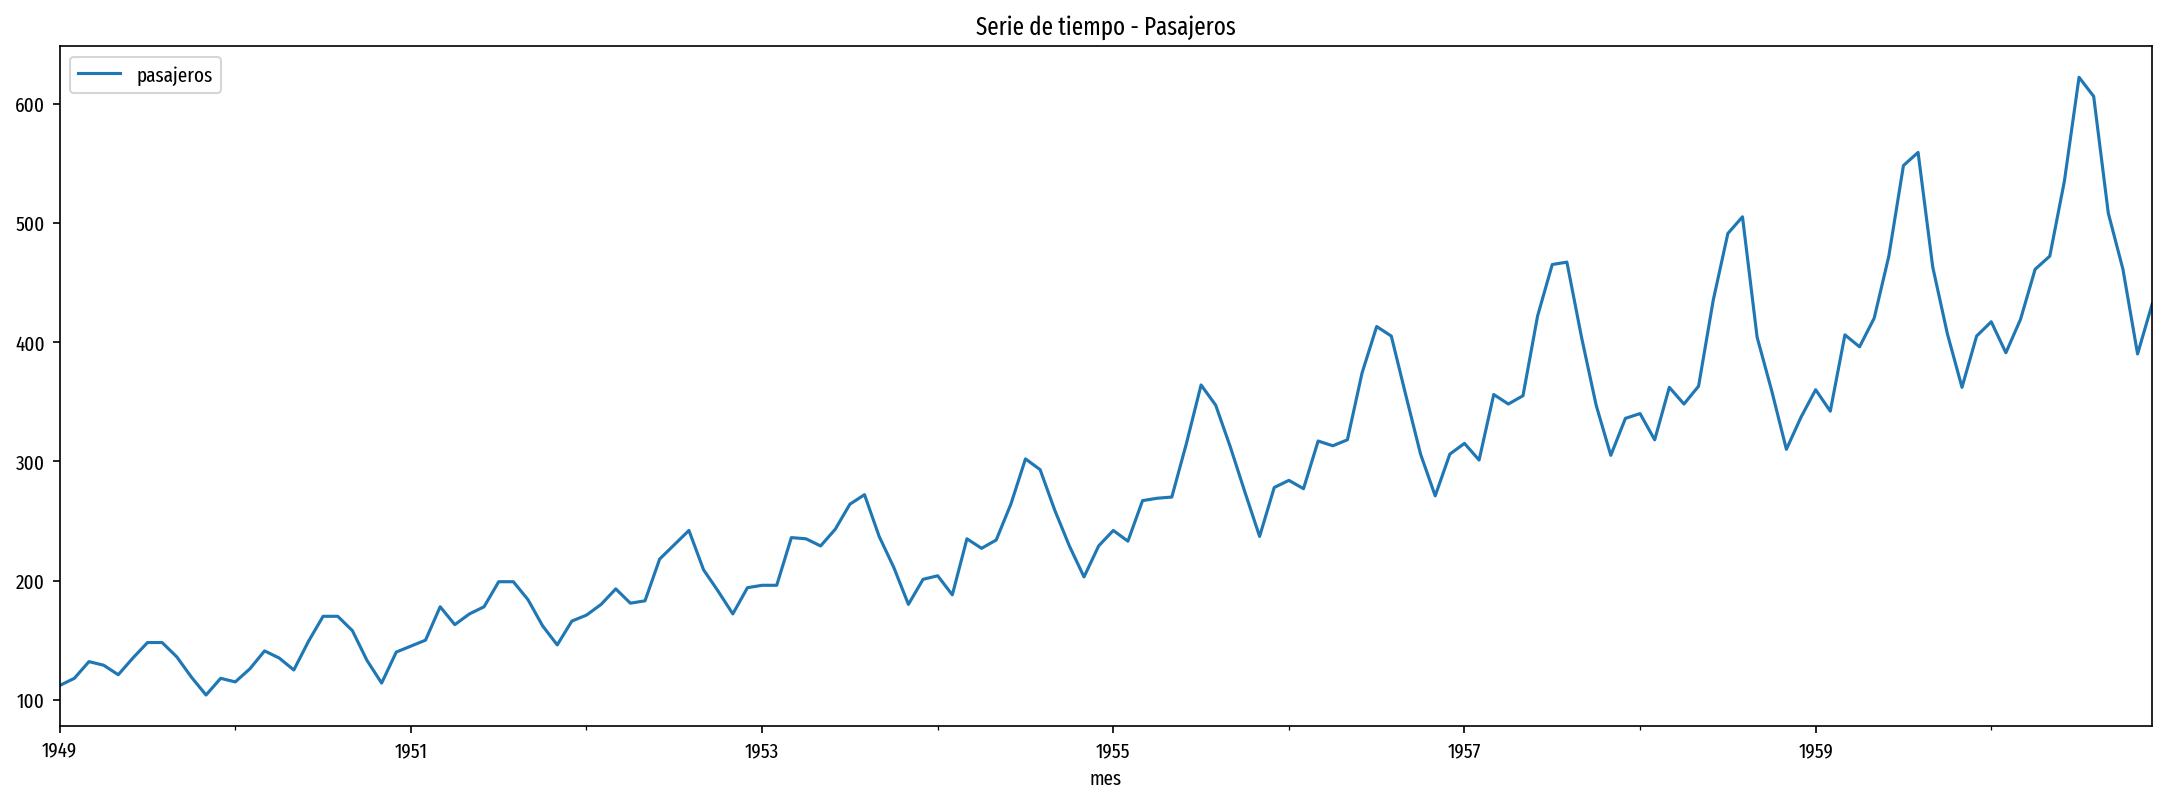

In [45]:
fig, ax = plt.subplots(figsize=(18,6))
data.plot(x='mes',y='pasajeros',ax=ax).set_title('Serie de tiempo - Pasajeros')


Podemos ver que la serie presenta una tendencia creciente y que posee cierta estacionalidad. Además la amplitud de la estacionalidad es mayor a medida que aumenta la pendiente de la tendencia, por lo que sería una serie multiplicativa.

## Descompisición de la varianza

In [47]:
result=seasonal_decompose(data['pasajeros'], model='multiplicable', period=12)

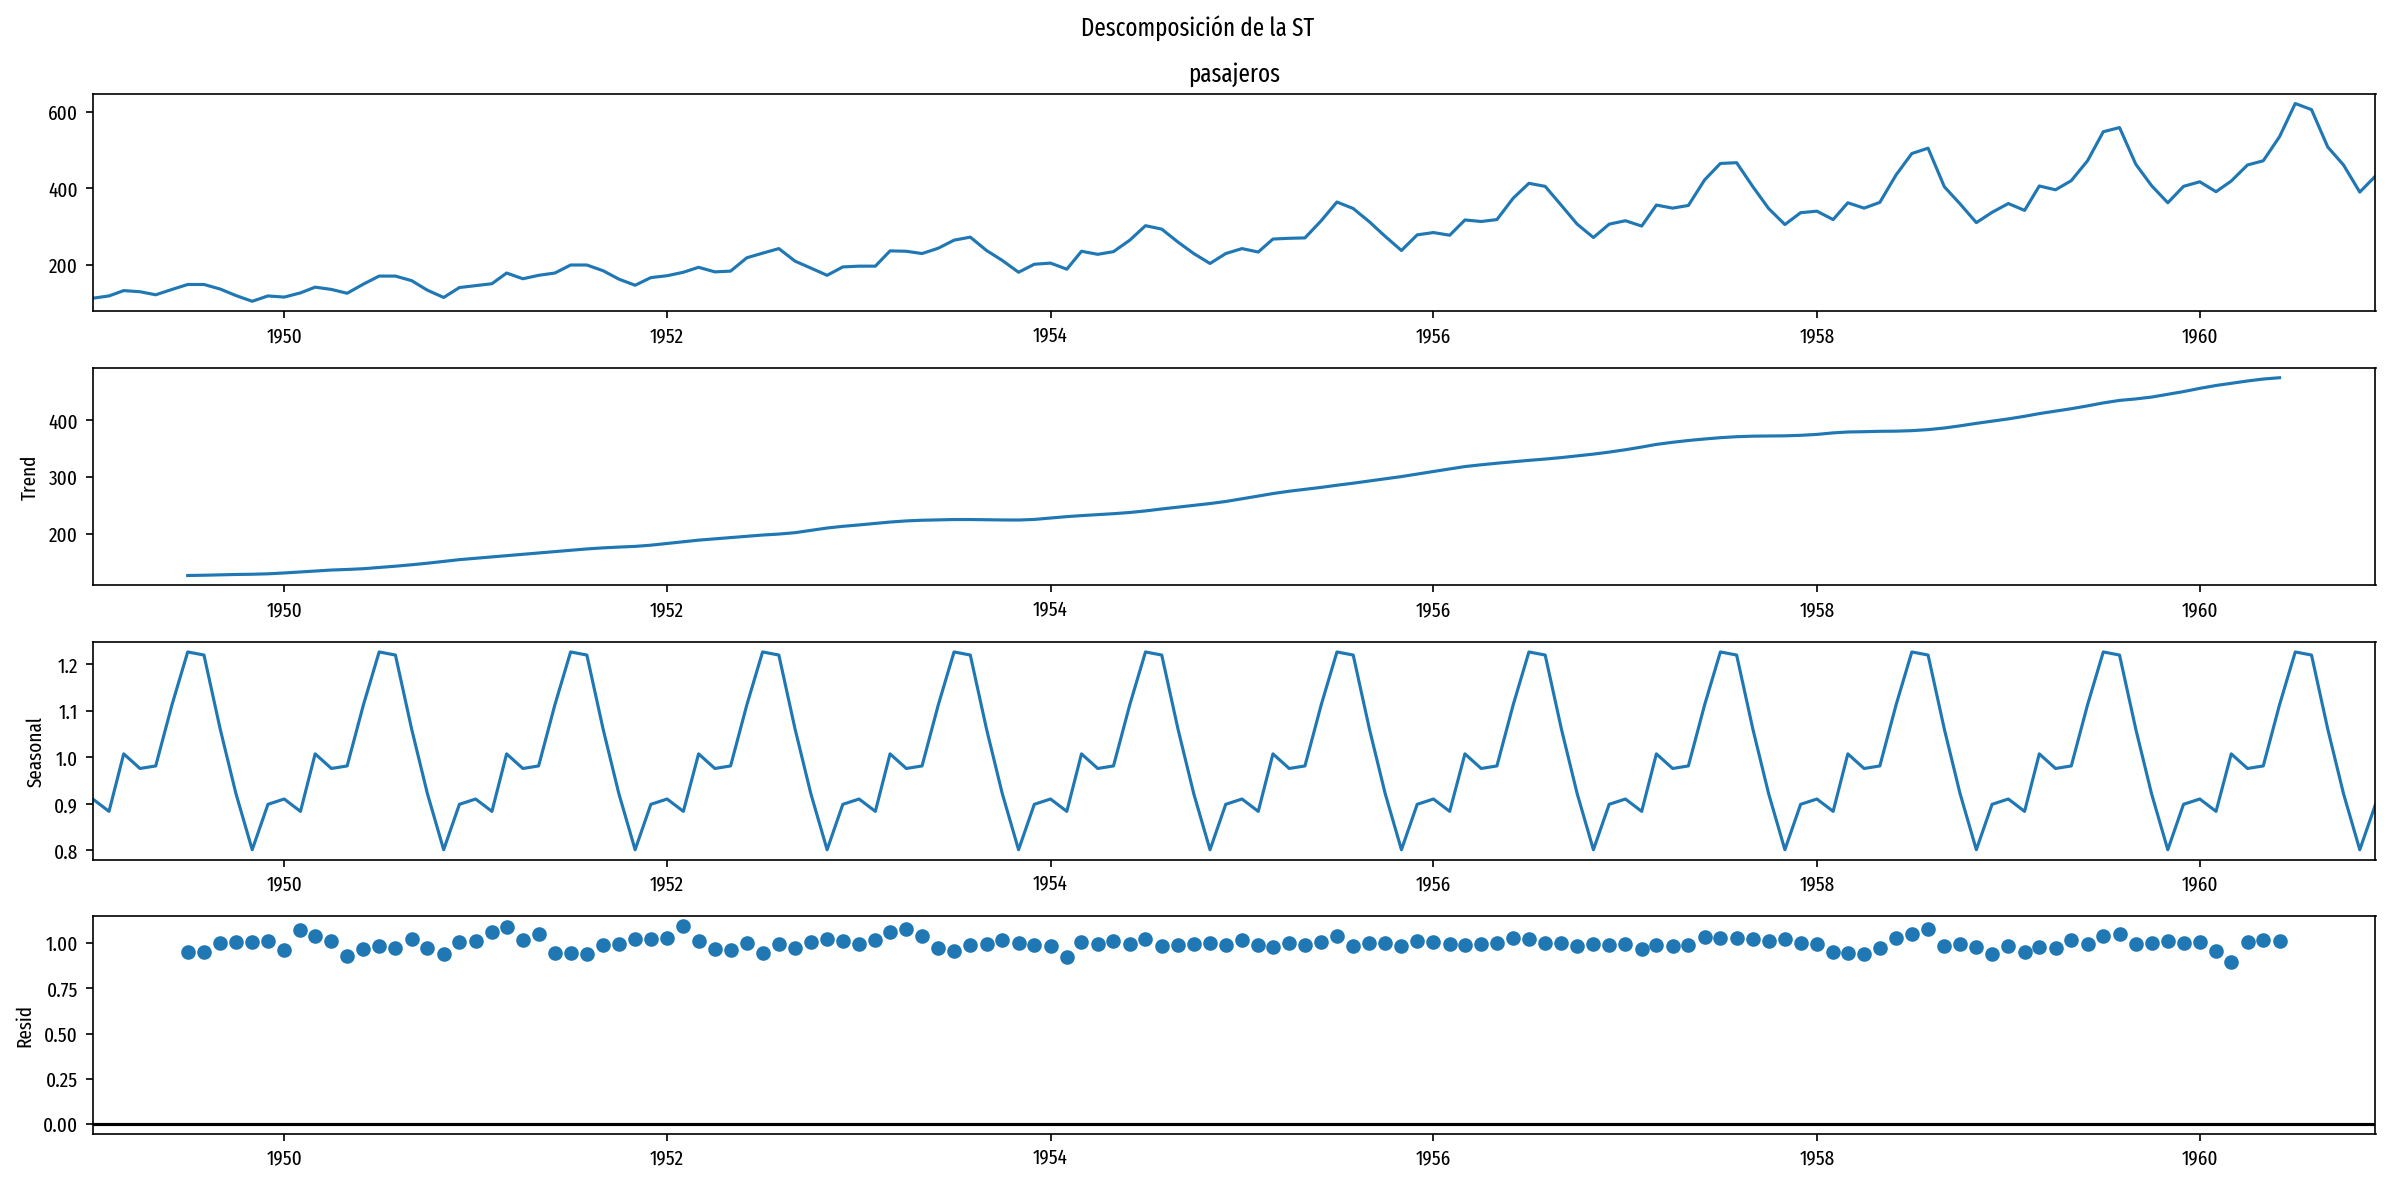

In [53]:
decomposition = seasonal_decompose(
    data.set_index('mes').pasajeros,
    period=12,
    model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(16, 8)
fig.suptitle('Descomposición de la ST')
fig.tight_layout()